## Setup

In [1]:
import os
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from absl import logging
logging.set_verbosity(logging.ERROR)

In [2]:
print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.7.0
• GPU Device Found.


## Read the processed data into the training dataset and validation dataset

In [3]:
TRAINING_DIR = "train_dir/"
VALIDATION_DIR = "validation_dir/"

In [4]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    train_datagen = ImageDataGenerator(rescale= 1./255.,
                                        rotation_range=180,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,             
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        fill_mode='nearest',
                                        horizontal_flip=True,
                                        vertical_flip=True)
    
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        class_mode="categorical",
                                                        target_size=(229, 229))

    
    validation_datagen = ImageDataGenerator(rescale=1./255.)
    
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  class_mode="categorical",
                                                                  target_size=(229, 229))
    
    return train_generator, validation_generator

In [5]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 5600 images belonging to 20 classes.
Found 1400 images belonging to 20 classes.


In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

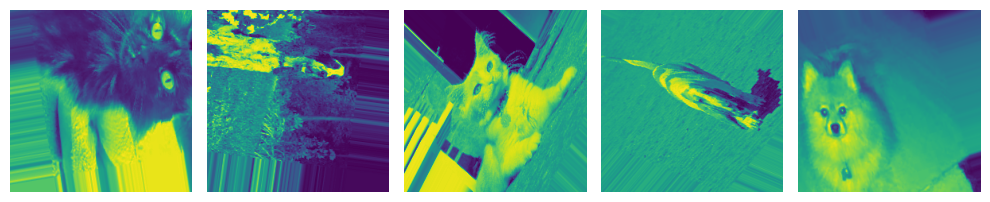

In [7]:
sample_training_images, _= next(train_generator)
plotImages(sample_training_images[:5])

## Creating a Callback class

In [8]:
class cb(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97):
            print("\nAccuracy has reached above 97%, training stops")
            self.model.stop_training = True # training will stop when accuracy and val_accuracy have reached >= 97%

callbacks = cb()

## Define, compile and Train the model

In [9]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4 with input size (299, 299) and output dimension 2048


In [10]:
do_fine_tuning = False #@param {type:"boolean"}

In [11]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [12]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),     
        tf.keras.layers.Dense(20,activation="softmax") 
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="categorical_crossentropy", metrics=['accuracy']) 

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4


In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 20)                2580      
                                                                 
Total params: 22,920,116
Trainable params: 1,117,332
Non-trainable params: 21,802,784
_________________________________________________________________


In [14]:
# Train the model
history = model.fit(train_generator,
                    epochs=200,
                    verbose=1,
                    validation_data=validation_generator,
                    callbacks=[callbacks]
                   )

Epoch 1/200
175/175 [==============================] - 43s 190ms/step - loss: 1.8123 - accuracy: 0.4673 - val_loss: 0.8029 - val_accuracy: 0.7500
Epoch 2/200
175/175 [==============================] - 30s 171ms/step - loss: 1.1760 - accuracy: 0.6195 - val_loss: 0.6275 - val_accuracy: 0.8029
Epoch 3/200
175/175 [==============================] - 30s 169ms/step - loss: 1.0908 - accuracy: 0.6463 - val_loss: 0.5996 - val_accuracy: 0.8107
Epoch 4/200
175/175 [==============================] - 30s 171ms/step - loss: 1.0194 - accuracy: 0.6673 - val_loss: 0.5353 - val_accuracy: 0.8314
Epoch 5/200
175/175 [==============================] - 30s 170ms/step - loss: 0.9843 - accuracy: 0.6711 - val_loss: 0.5906 - val_accuracy: 0.8114
Epoch 6/200
175/175 [==============================] - 30s 171ms/step - loss: 0.9370 - accuracy: 0.6871 - val_loss: 0.5305 - val_accuracy: 0.8257
Epoch 7/200
175/175 [==============================] - 30s 172ms/step - loss: 0.9414 - accuracy: 0.6882 - val_loss: 0.5124 -

Epoch 57/200
175/175 [==============================] - 30s 171ms/step - loss: 0.5910 - accuracy: 0.7920 - val_loss: 0.4492 - val_accuracy: 0.8500
Epoch 58/200
175/175 [==============================] - 30s 171ms/step - loss: 0.6126 - accuracy: 0.7923 - val_loss: 0.4400 - val_accuracy: 0.8557
Epoch 59/200
175/175 [==============================] - 30s 171ms/step - loss: 0.5958 - accuracy: 0.7927 - val_loss: 0.4676 - val_accuracy: 0.8500
Epoch 60/200
175/175 [==============================] - 30s 170ms/step - loss: 0.5811 - accuracy: 0.7989 - val_loss: 0.4368 - val_accuracy: 0.8514
Epoch 61/200
175/175 [==============================] - 30s 169ms/step - loss: 0.5847 - accuracy: 0.7975 - val_loss: 0.4787 - val_accuracy: 0.8486
Epoch 62/200
175/175 [==============================] - 30s 171ms/step - loss: 0.5949 - accuracy: 0.7923 - val_loss: 0.4439 - val_accuracy: 0.8529
Epoch 63/200
175/175 [==============================] - 30s 171ms/step - loss: 0.5922 - accuracy: 0.7971 - val_loss: 0

175/175 [==============================] - 30s 172ms/step - loss: 0.3727 - accuracy: 0.8709 - val_loss: 0.5024 - val_accuracy: 0.8507
Epoch 168/200
175/175 [==============================] - 30s 171ms/step - loss: 0.3817 - accuracy: 0.8641 - val_loss: 0.4921 - val_accuracy: 0.8479
Epoch 169/200
175/175 [==============================] - 30s 170ms/step - loss: 0.3699 - accuracy: 0.8702 - val_loss: 0.4687 - val_accuracy: 0.8543
Epoch 170/200
175/175 [==============================] - 30s 170ms/step - loss: 0.3540 - accuracy: 0.8768 - val_loss: 0.4591 - val_accuracy: 0.8593
Epoch 171/200
175/175 [==============================] - 30s 174ms/step - loss: 0.3783 - accuracy: 0.8652 - val_loss: 0.4591 - val_accuracy: 0.8557
Epoch 172/200
175/175 [==============================] - 30s 172ms/step - loss: 0.3552 - accuracy: 0.8800 - val_loss: 0.5110 - val_accuracy: 0.8457
Epoch 173/200
175/175 [==============================] - 30s 170ms/step - loss: 0.3671 - accuracy: 0.8714 - val_loss: 0.4583 -

### Training History

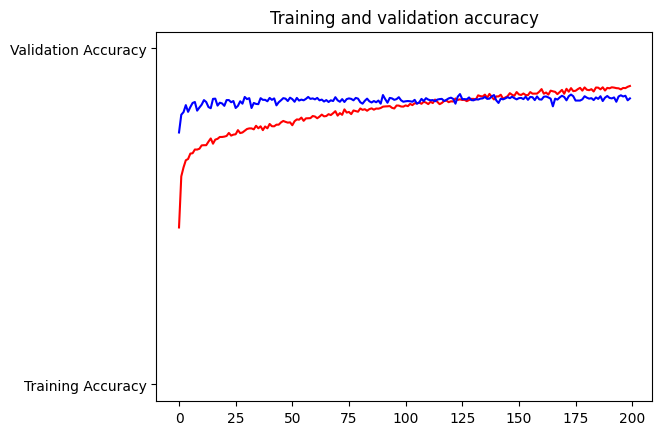

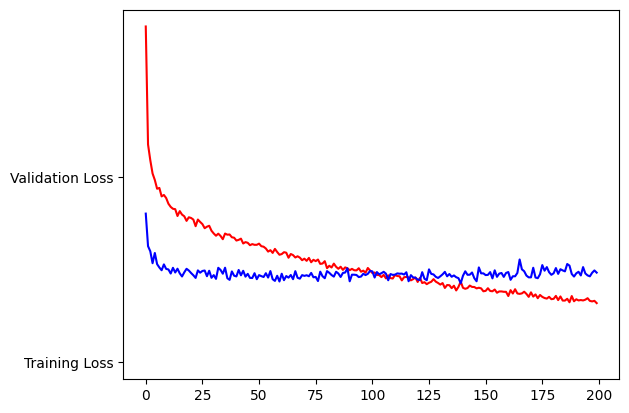

In [15]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

## save model format Keras HDF5

In [25]:
model.save('model_Inceptionv3.h5')

## Save model Exporting to TFLite

In [26]:
export_dir = 'saved_model/model_Inceptionv3'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/model_Inceptionv3\assets


INFO:tensorflow:Assets written to: saved_model/model_Inceptionv3\assets


In [27]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [28]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)# YOUR CODE HERE

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [29]:
tflite_model_file = pathlib.Path('./model_Inceptionv3.tflite')
tflite_model_file.write_bytes(tflite_model)

23366280